# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
from IPython.core.display import HTML
import pandas as pd
import numpy as np
import glob
import re
import string
import math

DATA_FOLDER = 'Data'  # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

This next cell is use to suppress Pandas FutureWarnings which always come up on ambiguity from Column/Index names

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Helper functions to Format result tables from DF

In [ ]:
def only_year_month(x):
    return str(x.year) + '-' + str(x.month)

def avg_table_daily(table):
    new_indexes = reversed(list(set(table.index.map(only_year_month))))
    avg_result = pd.DataFrame(index=new_indexes, columns=['Total Death (daily avg.)', 'New cases (daily avg.)'])
    index_list = table.index
    i = 0
    while i < len(index_list):
        new_ind = str(index_list[i].year) + '-' + str(index_list[i].month)
        num_days = (int(index_list[i+1].day) - int(index_list[i].day)) + 1
        avg_result['Total Death (daily avg.)'][new_ind] = (int(table['Total death'][index_list[i+1]]) - int(table['Total death'][index_list[i]])) / num_days
        avg_result['New cases (daily avg.)'][new_ind] = (int(table['New cases (cumul.)'][index_list[i+1]]) - int(table['New cases (cumul.)'][index_list[i]])) / num_days
        i =  i + 2

    return avg_result

Helper function to check headers from a list of files

In [ ]:
def check_headers(files):
    list_ = []
    for file_ in files:
        df = pd.read_csv(file_, header=None)
        list_.append(df.head(n=1))

    frame = pd.concat(list_)
    # Transpose to not drop record and better visualisation
    return frame.drop_duplicates().T

Helper function checking if dates are unique per file

In [ ]:
def are_date_unique_per_file(files, lowercase=False):
    cols=['Date']
    if lowercase:
        cols=['date']
    for file_ in files:
        df = pd.read_csv(file_, usecols=cols)
        #print(file_, df.shape)
        if df.drop_duplicates().shape[0] > 1:
            return False
    return True

## Liberia

### Check structures of the files

#### Headers

In [ ]:
allFiles = glob.glob(DATA_FOLDER + '/ebola/liberia_data/*.csv')

check_headers(allFiles)

In [ ]:
are_date_unique_per_file(allFiles)

We wanted to use first the "Newly reported deaths" column, but they were disrepedancies with the cumulated data, and the newly reported data did not indicate if it was confirmed, suspected, etc. For the "Total death/s in confirmed cases",  less than half of the files didn't contain the value for this field. So either we switch to no data or more data but overestimation. Then we decided to switch to cumulated "Total death/s in confirmed, probable, suspected cases".

In [ ]:
NEW_CASES = "New case/s (confirmed)"
TOTAL_NEW_CASES = "Total confirmed cases"
TOTAL_DEATH = "Total death/s in confirmed, probable, suspected cases"
NEWLY_REPORTED_DEATH = "Newly reported deaths"


# most of error are extra \n and spaces
#columns = list(map(lambda x: re.sub("\s\s+" , " ", x.replace("\n", "")), df.index.levels[0].values.tolist()))
def check_column_in_files(files, column_name, lower_case=False, decript=False):
    #Added lower_case boolean not to rewrite function as Sierre Leone data are lowercased.
    #Added descript boolean not to rewrite function as Guinea data are different.
    cols=['Variable', 'Date']
    if lower_case:
        cols=['variable', 'date']
    if decript:
        cols=['Description', 'Date']
    
    for file_ in allFiles:
        df = pd.read_csv(file_, index_col=cols).fillna(value=0)
        
        #df["edited_variable"] = df.index.levels[0].values
        #df["edited_variable"] = 
        new_values = list(map(lambda x: re.sub("\s\s+" , " ", x.replace("\n", "")), df.index.levels[0].values.tolist()))
        df.index = df.index.set_levels(levels=new_values, level=0)
        
        #print(df.index.levels[0])
        
        #result = False
        result = column_name in df.index
            
        
        
        if(column_name == TOTAL_DEATH):
            pass
            #print("{} {}".format(result, file_))
        if not result:
            if(column_name == TOTAL_DEATH):
                print(df.index.levels[0])
            return False
    
        
    return True


to_check = [NEW_CASES, TOTAL_DEATH, NEWLY_REPORTED_DEATH, TOTAL_NEW_CASES]
list(map(lambda x: check_column_in_files(allFiles, x), to_check))

So, the both lines are available in each file, however a quick check in the files indicates that the cell may be empty.

Below, we found out that there is many NA values for the lasts months, only totals are available which mixes confirmed, probable and suspected cases. We have chosen along the way to consider only *confirmed cases*, so we are going to drop those data. First, let's check how many data we are going to drop.

Also, there is discrependencies between New deaths reported and cumulated data.

For the new cases, we also are going to use the cumulated data, except for the last file, were it seems that the cumulated data has moved to the new cases column. We patch manually this

In the `2014-10-04-v142.csv` file, there is two Total deaths line, we keep only the second one

In [ ]:
allFiles = glob.glob(DATA_FOLDER + '/ebola/liberia_data/*.csv')

list_ = []

for file_ in allFiles:
    df = pd.read_csv(file_, index_col=['Variable', 'Date'])
    
    # Normalize variable column
    new_values = list(map(lambda x: re.sub("\s\s+" , " ", x.replace("\n", "")), df.index.levels[0].values.tolist()))
    df.index = df.index.set_levels(levels=new_values, level=0)
    
    data = df[["National"]]

    total_deaths = data.loc[TOTAL_DEATH]
    new_cases = data.loc[NEW_CASES]
    total_cases = data.loc[TOTAL_NEW_CASES]
    
    concatenated = pd.concat([total_deaths.tail(n=1), new_cases, total_cases], axis=1)
    concatenated.columns = ["Total death", "New cases", "New cases (cumul.)"]
    list_.append(concatenated)
    
frame = pd.concat(list_)

# keep only NaN value.
death_null = frame[frame["Total death"].isnull()].shape[0]
death_total = frame.shape[0]

cases_null = frame[frame["New cases"].isnull()].shape[0]
cases_total = frame.shape[0]

frame["New cases (cumul.)"]["12/9/2014"] = frame["New cases"]["12/9/2014"]
frame.index = pd.to_datetime(frame.index)

def remove_outliers(x,y):
    #print(x, y, x > y)
    if(x > y):
        return x
    return y

frame["corr"] = frame["New cases (cumul.)"].rolling(window=2).apply(lambda x: remove_outliers(x[0], x[1]))

frame["Month"] = frame.index.map(lambda x: x.month).astype(int)
frame["Day"] = frame.index.map(lambda x: x.day).astype(int)
frame.index = [frame["Month"], frame["Day"]]

a = pd.concat(
    [frame.groupby(['Month'])['Day'].min().reset_index(),
    frame.groupby(['Month'])['Day'].max().reset_index()]
).sort_index()
result = pd.merge(a, frame, on=["Month", "Day"], how="left")

result.index = pd.to_datetime(result[['Month','Day']].apply(lambda x : '{}-{}-2014'.format(x[0],x[1]), axis=1))
result = result.drop(["Month", "Day"], axis=1)

result

We can that there must have been a mistake in the New cases (cumul.) column at the end of October 2011 as the cumulative amount drops from 926 to 73. In our corralated New cases *(corr column)* we got a total of 2437 which is much more coherent with the following datas. We decided to use that summed amount for the calculations.

As explained before we will only consider the cumulative results as they are much more coherent et complete.

In [ ]:
result['New cases (cumul.)']['2014-10-31'] = result['corr']['2014-10-31']
result

#### Now putting all that togheter and averaging daily we get this results for the Liberia data:

In [ ]:
avg_result_L = avg_table_daily(result)
avg_result_L = avg_result_L.reindex(["2014-6", "2014-7", "2014-8", '2014-9', '2014-10', '2014-11', '2014-12'])
avg_result_L['Country'] = 'Liberia'
avg_result_L

## Sierre Leone

### Check structures of the files

#### Headers

In [ ]:
allFiles = glob.glob(DATA_FOLDER + '/ebola/sl_data/*.csv')
check_headers(allFiles)

In [ ]:
are_date_unique_per_file(allFiles, True)

For the Sierra Leone we decided to keep the *confirmed* number for the new cases and death, as it seemed to make more sense to keep only the amount of infected and dead we were sure about.

In [ ]:
TOTAL_NEW_CASES = "cum_confirmed"
TOTAL_DEATH = "death_confirmed"

to_check = [TOTAL_DEATH, TOTAL_NEW_CASES]
list(map(lambda x: check_column_in_files(allFiles, x, True, False), to_check))

As the total deaths data was missing from the last file for december (13-12-2014) we decided to keep the amounts (for every column) shown in the last file that was complete (05-12-2014). This is why we do not take the last two files in the calculations.

In [ ]:
list_ = []

for file_ in allFiles[:len(allFiles) - 2]:
    df = pd.read_csv(file_, index_col=['variable', 'date'])
    
    # Normalize variable column
    new_values = list(map(lambda x: re.sub("\s\s+" , " ", x.replace("\n", "")), df.index.levels[0].values.tolist()))
    df.index = df.index.set_levels(levels=new_values, level=0)
    
    data = df[["National"]]
    
    total_deaths = data.loc[TOTAL_DEATH]
    total_cases = data.loc[TOTAL_NEW_CASES]
    
    concatenated = pd.concat([total_deaths.tail(n=1), total_cases], axis=1)
    concatenated.columns = ["Total death", "New cases (cumul.)"]
    
    list_.append(concatenated)
    
    
    
frame = pd.concat(list_)
frame.index = pd.to_datetime(frame.index)
frame["Month"] = frame.index.map(lambda x: x.month).astype(int)
frame["Day"] = frame.index.map(lambda x: x.day).astype(int)
frame.index = [frame["Month"], frame["Day"]]

a = pd.concat(
    [frame.groupby(['Month'])['Day'].min().reset_index(),
    frame.groupby(['Month'])['Day'].max().reset_index()]
).sort_index()
result = pd.merge(a, frame, on=["Month", "Day"], how="left")

result.index = pd.to_datetime(result[['Month','Day']].apply(lambda x : '{}-{}-2014'.format(x[0],x[1]), axis=1))
result = result.drop(["Month", "Day"], axis=1)

result

#### Now putting all that togheter and averaging daily we get this results for the Sierra Leone data:

In [ ]:
avg_result_SL = avg_table_daily(result)
avg_result_SL = avg_result_SL.reindex(["2014-8", '2014-9', '2014-10', '2014-11', '2014-12'])
avg_result_SL['Country'] = 'Sierra Leone'
avg_result_SL

## Guinea

### Check structures of the files

#### Headers

In [ ]:
allFiles = glob.glob(DATA_FOLDER + '/ebola/guinea_data/*.csv')
check_headers(allFiles)

In [ ]:
are_date_unique_per_file(allFiles)

We can see that three columns are always available: Date, Description and Totals. We decided to use the total cumulative confirmed amount for deaths and new cases.

In [ ]:
TOTAL_NEW_CASES = "Total cases of confirmed"
TOTAL_DEATH = "Total deaths of confirmed"

to_check = [TOTAL_DEATH, TOTAL_NEW_CASES]
list(map(lambda x: check_column_in_files(allFiles, x, False, True), to_check))

In [ ]:
list_ = []

for file_ in allFiles[:len(allFiles)-1]:
    df = pd.read_csv(file_, index_col=['Description', 'Date'])
    
    # Normalize variable column
    new_values = list(map(lambda x: re.sub("\s\s+" , " ", x.replace("\n", "")), df.index.levels[0].values.tolist()))
    df.index = df.index.set_levels(levels=new_values, level=0)
    
    data = df[["Totals"]]
    
    total_deaths = data.loc[TOTAL_DEATH]
    total_cases = data.loc[TOTAL_NEW_CASES]
    
    concatenated = pd.concat([total_deaths.tail(n=1), total_cases], axis=1)
    concatenated.columns = ["Total death", "New cases (cumul.)"]
    
    list_.append(concatenated)
    
    
    
frame = pd.concat(list_)
frame.index = pd.to_datetime(frame.index)
frame["Month"] = frame.index.map(lambda x: x.month).astype(int)
frame["Day"] = frame.index.map(lambda x: x.day).astype(int)
frame.index = [frame["Month"], frame["Day"]]

a = pd.concat(
    [frame.groupby(['Month'])['Day'].min().reset_index(),
    frame.groupby(['Month'])['Day'].max().reset_index()]
).sort_index()
result = pd.merge(a, frame, on=["Month", "Day"], how="left")

result.index = pd.to_datetime(result[['Month','Day']].apply(lambda x : '{}-{}-2014'.format(x[0],x[1]), axis=1))
result = result.drop(["Month", "Day"], axis=1)

result

The guinea data for October 2014 only contained one day of data. We decided to drop it as it doesn't make much sense to return a daily average per month on one day.

#### Now putting all that togheter and averaging daily we get this results for the Guinea data:

In [ ]:
avg_result_G = avg_table_daily(result)
avg_result_G = avg_result_G.reindex(["2014-8", '2014-9'])
avg_result_G['Country'] = 'Guinea'
avg_result_G

### Putting everything together

In [ ]:
total_result = pd.concat([avg_result_L, avg_result_SL, avg_result_G])
total_result = total_result.set_index([total_result['Country'], total_result.index]).drop('Country', axis=1)
total_result

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

## Solution

To solve this exercice we will first load the metadata and modify the NA value to the *unknown* tag. After that we will load every MIDx.xls file in a separate DataFrame and store them in a list to be able to concat them together. While we load the files we will add a new column call *BARCODE* and store which file every row comes from. This will allow us to use a simple merge to fill the metadatas in for each line. Finaly to keep unique indexes we will use the tupple [*BARCODE, TAXON*]

In [ ]:
DATA_FILE = DATA_FOLDER + '/microbiome/'
METADATA = 'metadata'
MID = 'MID'
XLS = '.xls'

In [ ]:
metadata = pd.read_excel(DATA_FILE + METADATA + XLS).fillna('unknown')
metadata

In [ ]:
temp_df_list = []
for x in range(9):
    temp_df = pd.read_excel(DATA_FILE + MID + str(x+1) + XLS, header=None)
    temp_df['BARCODE'] = pd.Series([MID + str(x+1)]*len(temp_df))
    temp_df_list.append(temp_df)
taxons = pd.concat(temp_df_list)
taxons.columns = ['TAXON', 'COUNT', 'BARCODE']
taxons.head()

In [ ]:
final = taxons.merge(metadata, on='BARCODE', how='left').set_index(['BARCODE', 'TAXON'])
final.head()

In [ ]:
final.tail()

We can check that the index is unique and that there is no more NaN values


In [ ]:
final.index.is_unique

In [ ]:
final.isnull()

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [ ]:
HTML(filename=DATA_FOLDER+'/titanic.html')

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [52]:
#Load data
frame = pd.read_excel(DATA_FOLDER+'/titanic.xls')

### Cleanup

#### Tickets
To be able to describe the different atributes of this dataset we need to cleanup the dataset. For the ticket atribute we noticed that the tickets are described mostly by integers but in samoe cases there is text in front of the ticket number such as `'PC'`, `'.A.'`, ect... To clean this column we remove all the letters and punctuation that is around the ticket number. 

#### Age
Cleaning up the data regarding the age was done in the folowing way: 
- Samples containing null value as age were dropped. There was the possibility to assign random ages from the range `0-80` years but the distribution of these ages is unknown (i.e. require  additional analysis to be know) thus dropping these values was more reasnoable. 
- The minimal age is `0.1667` which we consider is a valid age, representing a fraction from year 

#### Embarked
The `embarked` column has only two null, and whit the same argument as for the age attribute, we decided to drop these values 

#### pclass, sex, survived
The columns of these attributes are fully populated and without strange values 

#### cabin 
The null values for the `cabin` attribute are droped only when we count number of passengers by floor. 

#### Other attributes
We didn't clean data regarding the other attributes since they are not used in the analysis

In [40]:
initial = len(frame)
#Ticket cleanup
frame.ticket = frame.ticket.map(lambda tickets: str(tickets).strip('{}{}'.format(string.ascii_letters, string.punctuation)).split(' ')[-1])
frame.ticket = frame.ticket.map(lambda tickets: 0 if len(tickets)==0 else int(tickets))

#Age cleanup
frame = frame[frame.age.notnull()]
frame = frame[frame.embarked.notnull()]
final = len(frame)

print("In total {} samples were dropped, out of {} initial number of samples".format(initial-final, initial))

In total 0 samples were dropped, out of 1044 initial number of samples


### 1.Describe the type and the value range of each attribute. Indicate and transform the attributes that can be Categorical.


In [46]:
print("\npclass \n range: {}\n type: {}".format(frame.pclass.unique(), frame.pclass.dtype))
print("\nsurvived \n range: {}\n type: {}".format(frame.survived.unique(), frame.survived.dtype))
print("\nsex \n range: {}\n type: {}".format(frame.sex.unique(), frame.sex.dtype))
print("\nembarked \n range: {}\n type: {}".format(frame.embarked.unique(), frame.embarked.dtype))
print("\nparch \n range: {}-{}\n type: {}".format(frame.parch.min(), frame.parch.max(), frame.parch.dtype))
print("\nsibsp \n range: {}-{}\n type: {}".format(frame.sibsp.min(), frame.sibsp.max(), frame.sibsp.dtype))
print("\nage \n range: {}-{}\n type: {}".format(frame.age.min(), frame.age.max(), frame.age.dtype))
print("\nticket \n range: {}-{}\n type: {}".format(frame.ticket.min(), frame.ticket.max(), frame.ticket.dtype))
print("\nfare \n range: {}-{}\n type: {}".format(frame.fare.min(), frame.fare.max(), frame.fare.dtype))
print("\nbody \n range: {}-{}\n type: {}".format(frame.body.min(), frame.body.max(), frame.body.dtype))
print("\nboat \n range: {}\n type: {}".format(frame.boat.unique(), frame.boat.dtype))
print("\ncabin \n range: {}\n type: {}".format(frame.cabin.unique(), frame.cabin.dtype))
print("\nname \n range: {}\n type: {}".format(frame.name.unique(), frame.name.dtype))
print("\nhome.dest \n range: {}\n type: {}".format(frame['home.dest'].unique(), frame['home.dest'].dtype))


pclass 
 range: [1, 2, 3]
Categories (3, int64): [1, 2, 3]
 type: category

survived 
 range: [1, 0]
Categories (2, int64): [1, 0]
 type: category

sex 
 range: [female, male]
Categories (2, object): [female, male]
 type: category

embarked 
 range: [S, C, Q]
Categories (3, object): [S, C, Q]
 type: category

parch 
 range: 0-6
 type: int64

sibsp 
 range: 0-8
 type: int64

age 
 range: 0.1667-80.0
 type: float64

ticket 
 range: 0-3101317
 type: int64

fare 
 range: 0.0-512.3292
 type: float64

body 
 range: 1.0-328.0
 type: float64

boat 
 range: [2 '11' nan '3' '10' 'D' '4' '9' '6' 'B' '8' 'A' '5' '7' 'C' '14' '2' '5 9'
 '13' '1' '15' '5 7' '8 10' '12' '16' '13 15 B' 'C D' '13 15']
 type: object

cabin 
 range: ['B5' 'C22 C26' 'E12' 'D7' 'A36' 'C101' nan 'C62 C64' 'B35' 'A23' 'B58 B60'
 'D15' 'C6' 'D35' 'C148' 'C97' 'B49' 'C99' 'C52' 'T' 'A31' 'C7' 'C103'
 'D22' 'E33' 'A21' 'B10' 'B4' 'E40' 'B38' 'E24' 'B51 B53 B55' 'B96 B98'
 'C46' 'E31' 'E8' 'B61' 'B77' 'A9' 'C89' 'E58' 'E49' 'E5

`pclass`, `survived`, `sex` and `embarked` can be considered as categorical attributes. They have at most 3 different values.

In [47]:
#Transform the attributes that can be `Categorical`. 
frame['pclass'] = frame.pclass.astype('category')
frame['survived'] = frame.survived.astype('category')
frame['sex'] = frame.sex.astype('category')
frame['embarked'] = frame.embarked.astype('category')

As mentioned above, some of the columns are not used in the later analysis, thus can be dropped from the initial frame. 

In [48]:
#Drop columns that won't be used furhter
clean_frame = frame.drop(['sibsp', 'parch', 'ticket', 'fare', 'body', 'home.dest', 'boat', 'name'], axis=1)

### 2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 

Since `sex`, `pclass` and `embarked` are categorical attributes, we can easily use `value_counts` and have the number of people in each category. For `age` we use intiervals to count the number of people in each age category. 

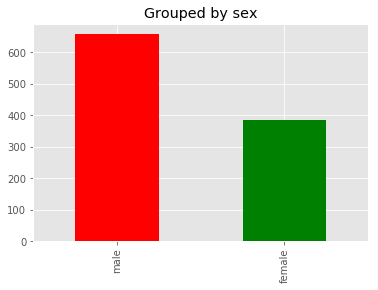

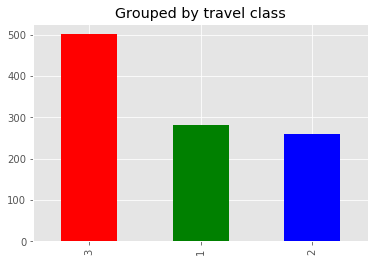

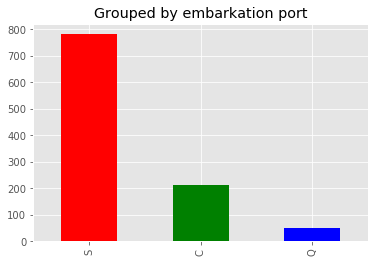

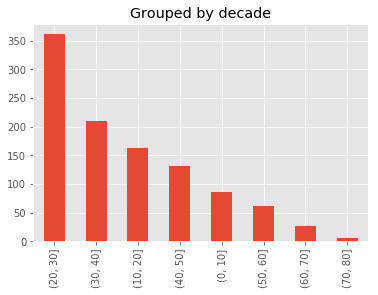

In [45]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

#Plot histograms for the *travel class*, *embarkation port*,
#*sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 

clean_frame['sex'].value_counts().plot(kind='bar', color=['r','g'], title='Grouped by sex')
plt.show()

clean_frame['pclass'].value_counts().plot(kind='bar', color=['r','g','b'], title='Grouped by travel class')
plt.show()

clean_frame['embarked'].value_counts().plot(kind='bar', color=['r','g','b'], title='Grouped by embarkation port')
plt.show()

pd.cut(clean_frame.age, [0,10,20,30,40,50,60,70,80]).value_counts().plot(kind='bar', title='Grouped by decade')
plt.show()

### 3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.

In [49]:
for c in clean_frame.cabin.values:
    if len(str(c).split(' '))>1:
        print(c) 

C22 C26
C22 C26
C22 C26
C22 C26
C62 C64
C62 C64
B58 B60
B58 B60
B51 B53 B55
B51 B53 B55
B51 B53 B55
B96 B98
B96 B98
B96 B98
B96 B98
B58 B60
C23 C25 C27
C23 C25 C27
C23 C25 C27
C23 C25 C27
C23 C25 C27
C23 C25 C27
D10 D12
D10 D12
B82 B84
B52 B54 B56
B57 B59 B63 B66
B57 B59 B63 B66
B57 B59 B63 B66
B57 B59 B63 B66
B57 B59 B63 B66
C55 C57
C55 C57
E39 E41
F G63
F G63
F E57
F G73
F G73


According to [this](https://www.encyclopedia-titanica.org/titanic-deckplans/g-deck.html) map, we assume that the starting letter for each value represent the floor on which the person stays. For the cases where we have for exemple 'F G63' we assume that the person stayed on floor F in part G cabin 63. When there are more than one value as cabin for the same person we noticed that these cabins are always on the same floor (showed above). 

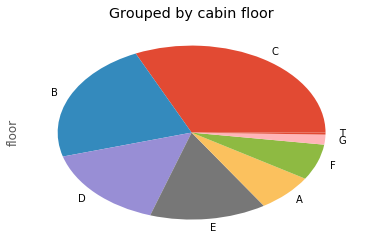

In [50]:
#Calculate the proportion of passengers by cabin floor. Present your results in a pie chart

#Add new column named floor
clean_frame['floor'] = clean_frame.cabin.dropna().map(lambda f: f[0])
#Make it categorical 
clean_frame['floor'] = clean_frame.floor.astype('category')
#Show the piechart
clean_frame['floor'].value_counts().plot(kind='pie', title='Grouped by cabin floor')
plt.show()

### 4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.

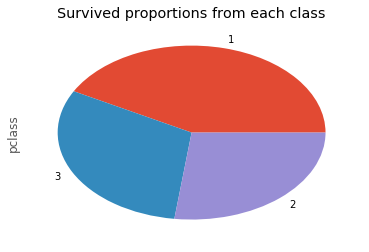

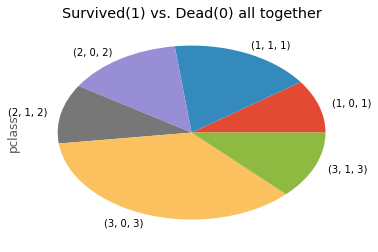

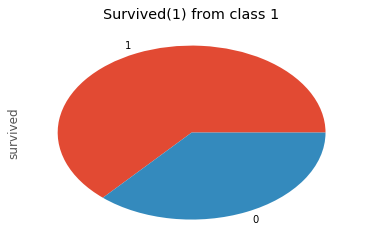

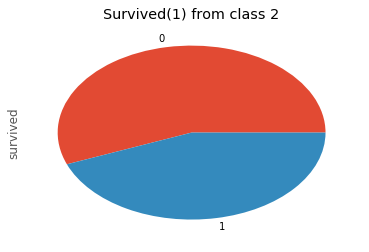

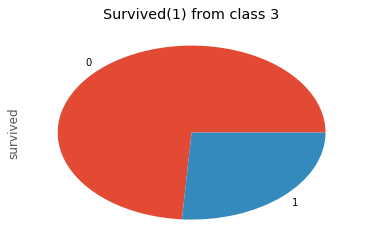

In [55]:
clean_frame[clean_frame.survived==1]['pclass'].value_counts().plot(kind='pie', title='Survived proportions from each class')
plt.show()
clean_frame.groupby(['pclass', 'survived']).pclass.value_counts().plot(kind='pie', title='Survived(1) vs. Dead(0) all together')
plt.show()
clean_frame[clean_frame.pclass==1]['survived'].value_counts().plot(kind='pie', title='Survived(1) from class 1')
plt.show()
clean_frame[clean_frame.pclass==2]['survived'].value_counts().plot(kind='pie', title='Survived(1) from class 2')
plt.show()
clean_frame[clean_frame.pclass==3]['survived'].value_counts().plot(kind='pie', title='Survived(1) from class 3')
plt.show()

### 5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.

Here we select only passengers that survived, we group them by `pclass` and `sex` and then we count the survived passengers for each group. 

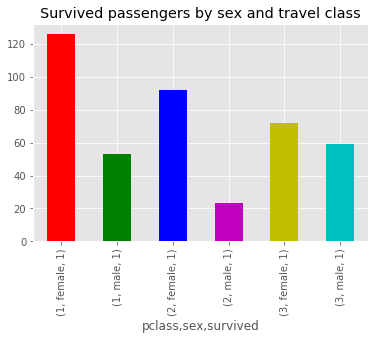

In [54]:
grouped = clean_frame[clean_frame.survived==1].groupby(['pclass', 'sex'])

grouped.survived.value_counts().plot(kind='bar', color=['r','g','b','m','y', 'c'], title='Survived passengers by sex and travel class')
plt.show()

### 6. Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a `DataFrame` with unique index.

Here we create a new column by_ages that contains the two different age categories: \[0.167, 28\] and (28, 80]. The two age categories doesn't have exactly the same number of passengers since splitting people of age 28 in two different groups doesn't look as proper solution. 

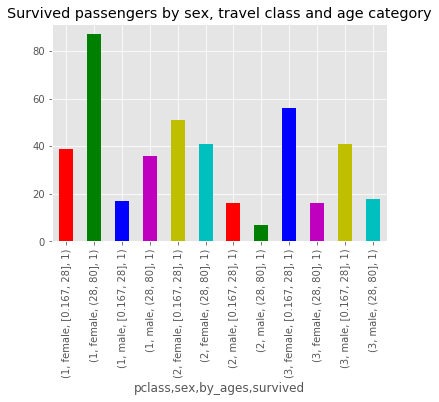

In [56]:
by_ages = pd.qcut(clean_frame.age, 2)
clean_frame['by_ages'] = by_ages

grouped = clean_frame[clean_frame.survived==1].groupby(['pclass', 'sex', 'by_ages'])
grouped.survived.value_counts().plot(kind='bar', color=['r','g','b','m','y', 'c'], title='Survived passengers by sex, travel class and age category')
plt.show()

In [59]:
#Present your results in a DataFrame with unique index.
clean_frame.index = clean_frame.set_index(['pclass', 'sex', 'by_ages', 'survived'])
clean_frame[clean_frame.survived == 1]

,pclass,survived,sex,age,cabin,embarked,floor,by_ages
"(29.0, B5, S, B)",1,1,female,29.0000,B5,S,B,"(28, 80]"
"(0.9167, C22 C26, S, C)",1,1,male,0.9167,C22 C26,S,C,"[0.167, 28]"
"(48.0, E12, S, E)",1,1,male,48.0000,E12,S,E,"(28, 80]"
"(63.0, D7, S, D)",1,1,female,63.0000,D7,S,D,"(28, 80]"
"(53.0, C101, S, C)",1,1,female,53.0000,C101,S,C,"(28, 80]"
"(18.0, C62 C64, C, C)",1,1,female,18.0000,C62 C64,C,C,"[0.167, 28]"
"(24.0, B35, C, B)",1,1,female,24.0000,B35,C,B,"[0.167, 28]"
"(26.0, nan, S, nan)",1,1,female,26.0000,NaN,S,NaN,"[0.167, 28]"
"(80.0, A23, S, A)",1,1,male,80.0000,A23,S,A,"(28, 80]"
"(50.0, B58 B60, C, B)",1,1,female,50.0000,B58 B60,C,B,"(28, 80]"
